This file is to develop a class to do PCP conformal inference

In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile
from data_gen_utils.data_gen import get_simu_data
from utils.utils import MyDataSet, get_idx_sets
from demo_settings import simu_settings
from ddpm.train_ddpm_now import TrainDDPM
from weighted_conformal_inference import WeightedConformalInference

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
plt.style.use(FIG_ROOT/"base.mplstyle")

# Params

In [5]:
setting = "setting3"

'setting3'

In [6]:
params = edict()

params.simu_setting = edict()
params.simu_setting.rho = 0.9
params.simu_setting.is_homo = False
params.simu_setting.n = 1000
params.simu_setting.d = 10
params.simu_setting.ntest = 1000
params.simu_setting.cal_ratio = 0.25 # for conformal inference
params.simu_setting.val_ratio = 0.15 # for tuning network
params.simu_setting.update(simu_settings[setting])
params.simu_setting.n = 3000
#params.simu_setting.d = 1000
pprint(params.simu_setting)


params.nrep = 50 # num of reptition for simulation
params.K = 20 # num of sps drawn from q(Y(1)|X)
params.save_snapshot = False
params.df_dtype = torch.float32
params.device="cpu"
params.n_jobs = 5
params.verbose = True
params.inf_bs = 40 # the inference batch, fct x K

params.ddpm_training = edict()
# Batch size during training
params.ddpm_training.batch_size = 256 
# Number of training epochs
params.ddpm_training.n_epoch = 1000
params.ddpm_training.n_infeat = 128
# Learning rate for optimizers
params.ddpm_training.lr = 0.001
params.ddpm_training.lr_gamma = 0.5
params.ddpm_training.lr_step = 1000
params.ddpm_training.test_intv = 5
params.ddpm_training.n_T = 200 # 100
params.ddpm_training.n_upblk = 1
params.ddpm_training.n_downblk = 1
params.ddpm_training.weight_decay = 1e-2
params.ddpm_training.early_stop = True
params.ddpm_training.early_stop_dict = {"early_stop_len":50, "early_stop_eps": -5e-4}
#params.ddpm_training.betas = [0.001, 0.5]

params.wconformal = edict()
# remove too large and too small in ws/mean(ws)
params.wconformal.nwthigh = 20
params.wconformal.nwtlow = 0.05
params.wconformal.useinf = False


params.hypo_test = edict()
params.hypo_test.alpha = 0.05 # sig level

params.prefix = ""
params.save_dir = f"demo_ddpm_{setting}_test1"
if not (RES_ROOT/params.save_dir).exists():
    (RES_ROOT/params.save_dir).mkdir()

{'cal_ratio': 0.25,
 'd': 10,
 'err_type': 'norm',
 'is_homo': False,
 'n': 3000,
 'ntest': 1000,
 'rho': 0.0,
 'val_ratio': 0.15}


# Some fns

In [7]:
def _gen_Y_given_X(X, ddpm, seed=1):
    c_all = torch.tensor(X, dtype=params.df_dtype).to(params.device);
    num_iters = int(np.ceil(c_all.shape[0]/params.inf_bs));
    x_0s = []
    if params.verbose:
        pbar = tqdm(range(num_iters), total=num_iters)
    else:
        pbar = range(num_iters)
    def _run_fn(ix):
        torch.set_default_dtype(params.df_dtype)
        torch.set_default_device(params.device)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        c_cur = c_all[(ix*params.inf_bs):(ix*params.inf_bs+params.inf_bs)]
        c_cur_mul = c_cur.repeat(params.K, 1);
        with torch.no_grad():
            x_0, _ = ddpm.sample(c_cur_mul, device=params.device, is_store=False);
        x_0 = x_0.cpu().numpy().reshape(-1);
        x_0 = x_0.reshape(params.K, -1);
        return x_0
    with Parallel(n_jobs=params.n_jobs) as parallel:
        x_0s = parallel(delayed(_run_fn)(ix) for ix in pbar)
    x_0s = np.concatenate(x_0s, axis=1).T;
    return x_0s
def _get_pred_intv(teY_hat, qv):
    intvs = np.stack([teY_hat-qv, teY_hat+qv]).T
    return merge_intervals(intvs)
def _get_metric(v, intvs):
    if not isinstance(v, np.ndarray):
        v = np.array(v)
    in_sets = np.sum([np.bitwise_and(v>intv[0], v<intv[1]) for intv in intvs], axis=0)
    intvs_len = np.sum([np.diff(intv) for intv in intvs])
    metrics = edict()
    metrics.in_sets = in_sets
    metrics.intvs_len = intvs_len
    return metrics

In [18]:
def _run_fn_PCP1(rep_ix, params, lr, n_infeat, n_T, weight_decay, n_blk):
    manualSeed = rep_ix
    random.seed(manualSeed)
    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True) # Needed for reproducible results
    params = edict(params.copy())
    params.ddpm_training.n_upblk = n_blk
    params.ddpm_training.n_downblk = n_blk
    params.ddpm_training.weight_decay = weight_decay
    params.ddpm_training.n_T = n_T
    params.ddpm_training.lr = lr
    params.ddpm_training.n_infeat = n_infeat
    
    torch.set_default_dtype(params.df_dtype)
    torch.set_default_device(params.device)
    
    
    data_train = get_simu_data(n=params.simu_setting.n, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho, 
                               err_type=params.simu_setting.err_type);
    data_test = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho,
                               err_type=params.simu_setting.err_type);
    
    cal_idxs, val_idxs, tr_idxs = get_idx_sets(all_idxs=np.where(data_train.T)[0], 
                                               ratios = [params.simu_setting.cal_ratio, params.simu_setting.val_ratio])
        
        
    # train q(Y(1)|X)
    data_train_ddpm = MyDataSet(Y=data_train.Y[tr_idxs], X=data_train.X[tr_idxs])
    data_val = edict()
    data_val.c =  data_train.X[val_idxs]
    data_val.x =  data_train.Y[val_idxs]
    
    input_params = params.ddpm_training.copy()
    input_params.pop("n_epoch")
    input_params.pop("early_stop")
    input_params.pop("early_stop_dict")
    myddpm = TrainDDPM(data_train_ddpm, save_dir=params.save_dir, verbose=params.verbose, prefix=f"rep{rep_ix}_1", 
                       device=params.device,
                       **input_params);
    
    myddpm.train(n_epoch=params.ddpm_training.n_epoch, 
                     data_val=data_val, save_snapshot=params.save_snapshot, 
                     early_stop=params.ddpm_training.early_stop, 
                     early_stop_dict=params.ddpm_training.early_stop_dict
                     )
    ddpm = myddpm.ddpm
    ddpm.eval()
    wcf = WeightedConformalInference(torch.tensor(data_train.X[cal_idxs], dtype=params.df_dtype), 
                                     torch.tensor(data_train.Y1[cal_idxs], dtype=params.df_dtype), 
                                     ddpm, ws_fn=None, verbose=2, 
                                     seed=manualSeed,
                                     n_jobs=params.n_jobs,
                                     inf_bs=params.inf_bs,
                                     device=params.device,
                                     wcf_params={
                                        "K": params.K, # num of sps for each X
                                        "nwhigh" : params.wconformal.nwthigh,
                                        "nwlow" : params.wconformal.nwtlow,
                                        "useinf": params.wconformal.useinf,
                                     })
    _get_len_intvs = lambda intvs: np.array([sum([np.diff(iv) for iv in intv])[0] for intv in intvs]);
    def _get_inset(vs, intvs):
        in_set = []
        for v, intv in zip(vs, intvs):
            in_set.append(np.sum([np.bitwise_and(v>iv[0], v<iv[1]) for iv in intv]))
        in_set = np.array(in_set)
        return in_set
    intvs = wcf(torch.tensor(data_test.X, dtype=params.df_dtype));
    len_intv = np.median(_get_len_intvs(intvs))
    prb = np.mean(_get_inset(data_test.Y1, intvs))
    
    return len_intv, prb, wcf

In [19]:
res1 = _run_fn_PCP1(rep_ix=0, params=params, lr=1e-2, n_infeat=128, n_T=100, weight_decay=1e-2, n_blk=1)

2024-01-05 21:42:29,061 - ddpm.train_ddpm_now - INFO - The results are saved at /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_setting3_test1.
2024-01-05 21:42:29,071 - ddpm.train_ddpm_now - INFO - The params is {'lr': 0.01, 'batch_size': 256, 'device': 'cpu', 'n_T': 100, 'n_infeat': 128, 'n_upblk': 1, 'n_downblk': 1, 'betas': [0.0001, 0.02], 'lr_gamma': 0.5, 'lr_step': 1000, 'test_intv': 5, 'weight_decay': 0.01}
2024-01-05 21:42:29,072 - ddpm.train_ddpm_now - INFO - Early stop params are {'early_stop_len': 50, 'early_stop_eps': -0.0005}


The num of params is 0.30m. 
Adjusting learning rate of group 0 to 1.0000e-02.


loss: 0.5368:  28%|████████████████████████▍                                                             | 284/1000 [00:09<00:24, 28.73it/s, val loss=0.598, reg_coef=-.000541]
2024-01-05 21:42:38,961 - weighted_conformal_inference - INFO - wcf params is {'K': 20, 'nwhigh': 20, 'nwlow': 0.05, 'useinf': False, 'cf_type': 'PCP'}
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 11.38it/s]


(5.0819807,
 0.951,
 <weighted_conformal_inference.WeightedConformalInference at 0x7fbc6851ac40>)

In [20]:
def _run_fn_PCP(rep_ix, params, lr, n_infeat, n_T, weight_decay, n_blk):
    manualSeed = rep_ix
    random.seed(manualSeed)
    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.use_deterministic_algorithms(True) # Needed for reproducible results
    params = edict(params.copy())
    params.ddpm_training.n_upblk = n_blk
    params.ddpm_training.n_downblk = n_blk
    params.ddpm_training.weight_decay = weight_decay
    params.ddpm_training.n_T = n_T
    params.ddpm_training.lr = lr
    params.ddpm_training.n_infeat = n_infeat
    
    torch.set_default_dtype(params.df_dtype)
    torch.set_default_device(params.device)
    
    
    data_train = get_simu_data(n=params.simu_setting.n, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho, 
                               err_type=params.simu_setting.err_type);
    data_test = get_simu_data(n=params.simu_setting.ntest, 
                               d=params.simu_setting.d, 
                               is_homo=params.simu_setting.is_homo, 
                               rho=params.simu_setting.rho,
                               err_type=params.simu_setting.err_type);
    
    cal_idxs, val_idxs, tr_idxs = get_idx_sets(all_idxs=np.where(data_train.T)[0], 
                                               ratios = [params.simu_setting.cal_ratio, params.simu_setting.val_ratio])
        
        
    # train q(Y(1)|X)
    data_train_ddpm = MyDataSet(Y=data_train.Y[tr_idxs], X=data_train.X[tr_idxs])
    data_val = edict()
    data_val.c =  data_train.X[val_idxs]
    data_val.x =  data_train.Y[val_idxs]
    
    input_params = params.ddpm_training.copy()
    input_params.pop("n_epoch")
    input_params.pop("early_stop")
    input_params.pop("early_stop_dict")
    myddpm = TrainDDPM(data_train_ddpm, save_dir=params.save_dir, verbose=params.verbose, prefix=f"rep{rep_ix}_2", 
                       device=params.device,
                       **input_params);
    
    
    def _inner_fn(data_set, ddpm):
        # weight function
        def wtfun(x):
            if x.ndim == 1:
                x = x.reshape(1, -1)
            # for unconditional weight
            return np.ones(x.shape[0])
            
        # get the weight and nonconformity score for each data point in cal set
        x_0s = _gen_Y_given_X(data_train.X[cal_idxs], ddpm, manualSeed)
        ws = wtfun(data_train.X[cal_idxs]);
        Es = np.abs(x_0s -  data_train.Y1[cal_idxs][:, None]).min(axis=1);
                
        def _run_fn2(te_idx):
            torch.set_default_dtype(params.df_dtype)
            teX = data_set.X[te_idx]
            teY1 = data_set.Y1[te_idx]
            tetau = data_set.tau[te_idx]
            
            # get qv for current test pt
            ws_wtest = np.concatenate([ws, wtfun(teX)]);
            Es_winf = np.concatenate([Es, [np.inf]]);
            nws_wtest = ws_wtest/ws_wtest.mean();
            nws_wtest[nws_wtest<params.wconformal.nwtlow] = params.wconformal.nwtlow
            nws_wtest[nws_wtest>params.wconformal.nwthigh] = params.wconformal.nwthigh
            qt = (1 + nws_wtest[-1]/ nws_wtest[:-1].sum()) * (1 - params.hypo_test.alpha)
            if qt <= 1:
                qv_cur = weighted_quantile(Es, [qt], sample_weight=ws_wtest[:-1])[0];
            else:
                if params.wconformal.useinf:
                    qv_cur = np.inf
                else:
                    qv_cur = np.max(Es)
            
            intvs = _get_pred_intv(teYs_hat[te_idx], qv_cur)
            res = _get_metric([teY1, tetau], intvs)
            res["qv_cur"] = qv_cur
            res["qt"] = qt
            res["intvs"] = intvs
            return res
            
        teYs_hat = _gen_Y_given_X(data_set.X, ddpm, manualSeed);
        pbar2 = range(data_set.X.shape[0])
        with Parallel(n_jobs=1) as parallel:
            test_res = parallel(delayed(_run_fn2)(te_idx) for te_idx in pbar2)
            
        prbs = np.mean([res['in_sets'] for res in test_res], axis=0)
        mlen = np.median([res['intvs_len'] for res in test_res])
        qvs =np.array([res['qt'] for res in test_res])
        return prbs, mlen, Es
    
    data_val1 = edict()
    data_val1.X =  data_train.X[val_idxs]
    data_val1.Y =  data_train.Y[val_idxs]
    data_val1.Y1 =  data_train.Y1[val_idxs]
    data_val1.tau =  data_train.tau[val_idxs]
    
    myddpm.train(n_epoch=params.ddpm_training.n_epoch, 
                     data_val=data_val, save_snapshot=params.save_snapshot, 
                     early_stop=params.ddpm_training.early_stop, 
                     early_stop_dict=params.ddpm_training.early_stop_dict
                     )
    ddpm = myddpm.ddpm
    ddpm.eval()
    prbs1, mlen1, qvs = _inner_fn(data_test, ddpm)
    return mlen1, prbs1, qvs

In [21]:
res = _run_fn_PCP(rep_ix=0, params=params, lr=1e-2, n_infeat=128, n_T=100, weight_decay=1e-2, n_blk=1);

2024-01-05 21:42:47,585 - ddpm.train_ddpm_now - INFO - The results are saved at /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_setting3_test1.
2024-01-05 21:42:47,595 - ddpm.train_ddpm_now - INFO - The params is {'lr': 0.01, 'batch_size': 256, 'device': 'cpu', 'n_T': 100, 'n_infeat': 128, 'n_upblk': 1, 'n_downblk': 1, 'betas': [0.0001, 0.02], 'lr_gamma': 0.5, 'lr_step': 1000, 'test_intv': 5, 'weight_decay': 0.01}
2024-01-05 21:42:47,595 - ddpm.train_ddpm_now - INFO - Early stop params are {'early_stop_len': 50, 'early_stop_eps': -0.0005}


The num of params is 0.30m. 
Adjusting learning rate of group 0 to 1.0000e-02.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 12.15it/s]


In [22]:
res

(5.0819826,
 array([0.951, 1.   ]),
 array([1.83730238e-02, 2.28574316e-02, 5.37217478e-02, 4.24844872e-02,
        7.48866134e-04, 2.74115060e-02, 1.22114961e-01, 3.56649059e-02,
        1.91612872e-02, 1.69555205e-02, 4.07345748e+00, 7.74551422e-02,
        5.16548243e-03, 1.11589320e-02, 1.82022484e-02, 1.21771947e+00,
        1.05411064e-01, 7.58503052e-02, 6.48781060e-01, 1.61802287e-01,
        5.65773950e-02, 1.21490830e-01, 3.20065614e-02, 5.18765578e-02,
        3.27108651e-02, 3.97703772e-03, 1.00182895e-01, 3.88572196e-02,
        6.06593118e-02, 1.82802533e-01, 8.98421766e-02, 3.11758670e-02,
        6.31832539e-03, 8.89224833e-01, 3.94736600e-02, 3.10839363e-02,
        8.78949773e-02, 4.07488797e-02, 1.92763286e-01, 5.68760184e-03,
        2.95402411e-02, 3.36643023e-02, 6.46978636e-02, 5.59540963e-03,
        7.62470486e-02, 7.20250567e-02, 8.11356587e-02, 4.60825933e-03,
        5.04843004e-02, 1.24311122e-01, 3.22138226e-02, 4.20337226e-02,
        8.07251679e-03, 2.98

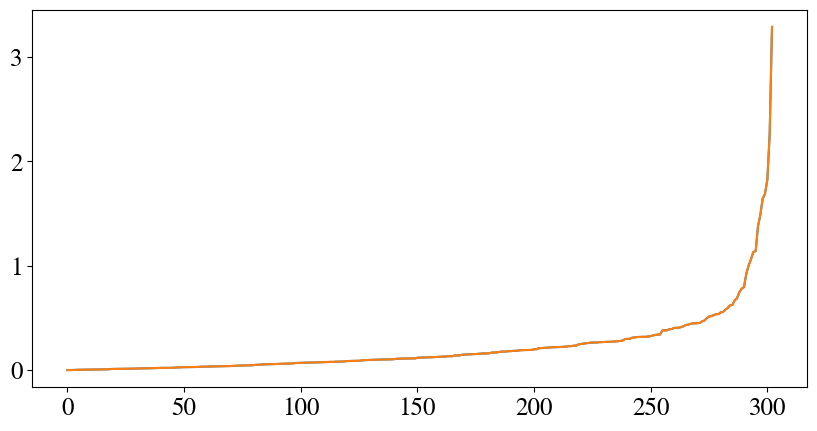

In [46]:
plt.plot(np.sort(res1[2]))
plt.plot(np.sort(res[2].Es.numpy()))